In [1]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import cv2

try: cv2.setNumThreads(0)
except: pass
from caiman import movie
import os
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from itertools import product
from collections import OrderedDict

from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))

from physio_def_1 import *
from matplotlib.colors import LogNorm

from numeric import *
from collections import Counter

In [120]:
try: cv2.setNumThreads(0)
except: pass

In [63]:
# some definitions
def climb(x,blurredWeights,diag=True,min_gradient = 0):
    dims = blurredWeights.shape
    # x = (60,60)
    x = x+(blurredWeights[x[0],x[1]],)
    xs = [x]
    for i in range(100):
        vs = []
        for di,dj in product([-1,0,1],[-1,0,1]):
            if not diag:
                if di*dj!=0: continue
            i,j = x[0]+di,x[1]+dj
            if i<0 or i>=dims[0] or j<0 or j>=dims[1]:
                continue
            vs += [(i,j,blurredWeights[i,j])]
        x1 = vs[np.argmax(vs,axis=0)[-1]]
        dx = x1[-1]-x[-1]
        if dx<=0:
            break
        elif dx<=min_gradient:
            return (None,)
        else:
            x = x1
            xs += [x]
    return x[:2]


def crawlDict(image, th=-np.inf, diag=False, min_gradient=0):
    A_ = [(i,j)+climb((i,j),image,diag=diag,min_gradient=min_gradient) for i,j in product(range(image.shape[0]),range(image.shape[1])) if image[i,j]>th]
    A_ = [el for el in A_ if el[-1] is not None]
    B_ = OrderedDict()
    for (i0,j0,i1,j1) in A_:
        if (i1,j1) not in B_:
            B_[(i1,j1)] = []
        B_[(i1,j1)] += [(i0,j0)]
    return B_

def edges2nodes(x,start=0,direction=1):
    if np.array(x[0]).shape != (2,2):
        x = [(el[:2],el[2:]) for el in x]
    nodes = list(x[start][::direction])

    for i in range(len(x)-1):
        nexts = [edge for edge in x if (edge[0]==nodes[-1] or edge[1]==nodes[-1])]
        for cand in np.unique(sum(nexts,()),axis=0):
            if tuple(cand) not in nodes:
                nodes += [tuple(cand)]
    return nodes

class Regions:
    def __init__(self, image, th=-np.inf, diag=False, min_gradient=0):
        from pandas import DataFrame
        A_ = [(i,j)+climb((i,j),image,diag=diag,min_gradient=min_gradient) for i,j in product(range(image.shape[0]),range(image.shape[1])) if image[i,j]>th]
        A_ = [el for el in A_ if el[-1] is not None]
        B_ = OrderedDict()
        for (i0,j0,i1,j1) in A_:
            if (i1,j1) not in B_:
                B_[(i1,j1)] = []
            B_[(i1,j1)] += [(i0,j0)]
        self.df = DataFrame(OrderedDict([
            ("peak",list(B_.keys())),
            ("pixels",list(B_.values()))
        ]))
        self.df["peakValue"] = [image[p] for p in B_]
        self.df["size"] = [len(B_[p]) for p in B_]
#         self.peaks = list(B_.keys())
#         self.pixels = list(B_.values())
        self.calcEdgeIds()
        self.calcEdges()
        self.df["boundary"] = [edges2nodes(self.df["edges"][j]) for j in self.df.index]
        self.calcNNmap()
        self.image = image
    
    @property
    def peak(self):
        return self.df["peak"]
    @property
    def pixels(self):
        return self.df["pixels"]
    @property
    def edges(self):
        return self.df["edges"]
    
    def calcEdgeIds(self):
        dround = np.vstack([(-1,-1),(-1, 1),( 1, 1),( 1,-1),(-1,-1)])
        dedges = []
        for el in zip(dround[:-1],dround[1:]):
            el = np.array(el)+1
            el = np.vstack(sorted(el,key=np.linalg.norm))-1
            dedges += [el*.5]
        dedges = np.stack(dedges)
        edgeID = OrderedDict()
        for k,pixelSet in zip(self.peak,self.pixels):
            for x,y in pixelSet:
                edges = dedges.copy()
                edges[...,0] += x
                edges[...,1] += y
                for edge in edges.reshape((-1,4)):
                    edge = tuple(edge)
                    if edge not in edgeID:
                        edgeID[edge] = []
                    edgeID[edge] += [k]
                    if len(edgeID[edge])==2 and edgeID[edge][0]==edgeID[edge][1]:
                        del edgeID[edge]
        self.edgeIDs = edgeID
    
    def calcEdges(self):
        invEdgeID = OrderedDict()
        if "edgeIDs" not in locals():
            self.calcEdgeIds()
        for k in self.edgeIDs:
            for p in self.edgeIDs[k]:
                if p not in invEdgeID:
                    invEdgeID[p] = []
                invEdgeID[p] += [k]
#         self.edges = OrderedDict([(p,invEdgeID[p]) for p in self.peaks])
        self.df["edges"] = [invEdgeID[p] for p in self.peak]
    
#     @property
    def getEdges(self,ix=None):
        if ix is None:
            out = sum(self.edges,[])
        else:
            out = sum(self.df.loc[ix,"edges"],[])
        out = np.unique(out,axis=0)
        return out
    
    def plotEdges(self, ix=None, ax=None, image =True, imkw_args = {"cmap":"Greys_r"}, separate=False):
        from matplotlib.colors import LogNorm
        if ax is None:
            ax = plt.subplot(111)
        if image:
            ax.imshow(self.image,norm=LogNorm(),**imkw_args)
        if separate:
            for i in ix:
                c = "C%i"%(i%10)
                for el in self.df.loc[i,"edges"]:
                    y,x = np.array(el).reshape((2,2)).T
                    ax.plot(x,y,lw=.8,c=c)
        else:
            for el in self.getEdges(ix=ix):
                y,x = np.array(el).reshape((2,2)).T
                ax.plot(x,y,"k",lw=.5)
            
            
    def plotPeaks(self, ix=None, ax=None, image=False, ms=1, labels=False):
        if ax is None:
            ax = plt.subplot(111)
        if image:
            ax.imshow(self.image)
        if ix is None:
            peaks = self.df["peak"]
            sizes = self.df["size"]**.5*ms
        else:
            peaks = self.df.loc[ix,"peak"]
            sizes = self.df.loc[ix,"size"]**.5*ms
        for ms,p in zip(sizes,peaks):
            i = self.peak2idx[p]
            c = "C%i"%(i%10)
            ax.plot(*p[::-1],marker="o",mfc="none",ms=ms,c=c)
            if labels:
                ax.text(*p[::-1],s=str(i),color=c)
    
    def calcNNmap(self):
        from bidict import bidict
        peak2idx = bidict([(peak,j) for j,peak in zip(self.df.index,self.df.peak)])
        self.peak2idx = peak2idx
        neighborsMap = {k:[] for k in self.peak}
        for edge in self.edgeIDs:
            if len(self.edgeIDs[edge])>1:
                for e1,e2 in product(self.edgeIDs[edge],self.edgeIDs[edge]):
                    if e1==e2: continue
                    if e2 not in neighborsMap[e1]:
                        neighborsMap[e1] += [e2]
        self.df["neighbors"] = [[peak2idx[pp] for pp in neighborsMap[p]] for p in self.peak]
        self.df["Nneighbors"] = self.df["neighbors"].apply(len)
        
    def purge_lones(self,min_size=4):
        toDel = []
        for i in self.df.index:
            if self.df.loc[i,"size"]<min_size and self.df.loc[i,"Nneighbors"]==0:
                toDel += [i]
        self.df = self.df.drop(index=toDel)
        print ("deleted %i rois"%len(toDel))
    
    def calcTraces(self, movie_):
        traces = np.ones((len(self.df),len(movie_)))*np.nan
        for i,ix in enumerate(self.df.index):
            x = self.df.loc[ix,"pixels"]
            x = [ el[0] for el in x ] , [ el[1] for el in x ]
            traces[i] = movie_[ :, x[0], x[1] ].mean(axis=1)
        print (traces.shape, )
        self.df["trace"] = list(traces)

# Importing

In [40]:
npzFiles = [
    "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_1_Series006.npz",
    "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_2_Series007.npz",
    "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_3_Series008.npz"
    
#     "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_1_Series006-008_motcor.npz"
    
#     "local_data/testdir/Experiment38a_18_Series040.npz"
#     "local_data/testdir/Experiment38a_7_Series016.npz"
]
# npzFile = f"/Volumes/physio/team/slakrupnik/project/experiments/Sandra/{row.date}/{row.filename.split('_')[0]}/{row.filename}.npz"
metadata = pd.DataFrame([pd.read_csv(npzFile.replace("npz","txt")).loc[0] for npzFile in npzFiles])

In [41]:
if len(metadata)>1:
    assert metadata.X.std()==0
    assert metadata.Y.std()==0
    assert metadata.freq.std()/metadata.freq.mean()<1e-3
    print ((metadata["T"]/metadata["freq"]/60).sum(), "minutes")
    origFreq = metadata.freq.mean()
    metadata["T"] = metadata["T"].sum()
    metadata = pd.Series(metadata.iloc[0])
    metadata["freq"] = origFreq
else:
    metadata = metadata.iloc[0]
    origFreq = metadata.freq
    print (metadata["T"]/metadata.freq/60, "minutes")

65.62319308464636 minutes


In [42]:
baseName = getBaseName(npzFiles)

In [ ]:
if os.path.isfile(baseName+"_motcor.npz"):
    npzFile = baseName+"_motcor.npz"
    npzFileHandle = np.load(npzFile)
    template = npzFileHandle["template"]
    m_orig = movie(npzFileHandle['data'])
else:
    orig_images = import_npz_files(npzFiles)
    m_orig = movie(orig_images.astype("float32"))
    del orig_images
m_orig.fr = origFreq

In [54]:
time = np.arange(len(m_orig)).astype(np.float32)/metadata.freq
allTrace = m_orig.mean(axis=(1,2))
Nsatur = np.sum(m_orig>m_orig.max()-1, axis=(1,2))

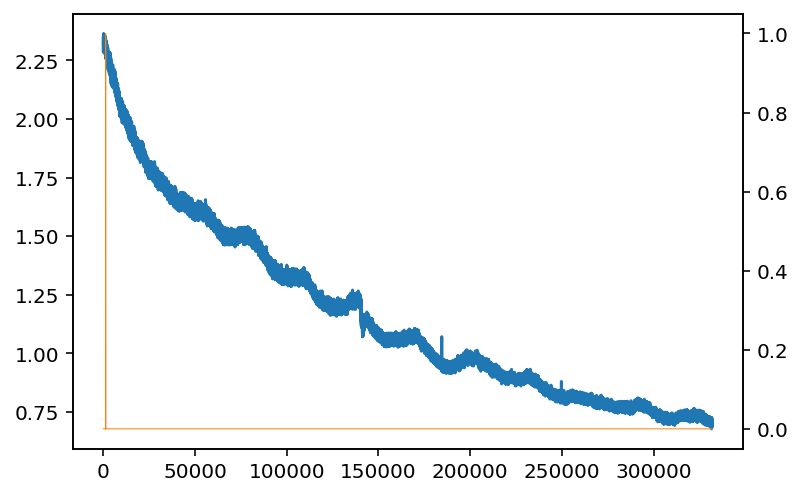

In [55]:
plt.plot(allTrace)
plt.twinx()
plt.plot(Nsatur,"C1",lw=.5)

In [56]:
# ccs = OrderedDict()

# %%capture
# for ks,s in [(3,.01), (3,.5), (5,1), (7,1.5)]:
#     m_blur = m_orig.copy()
#     m_blur.gaussian_blur_2D(ks,ks,s,s)
#     ccs[(ks,s)] = m_blur.local_correlations(eight_neighbours=True,swap_dim=False)

# fig, axs = plt.subplots(2,2,figsize=(11,9))
# axs = axs.flatten()
# for ax,k in zip(axs,ccs):
#     x = ccs[k]
#     im = ax.imshow(x, vmin=-np.abs(x).max(), vmax=+np.abs(x).max(),cmap="bwr_r")
#     plt.colorbar(im,ax=ax,shrink = .8)
#     ax.set_title(str(k))

In [124]:
def get_sep_th(blurredWeights):
    from scipy.stats import gaussian_kde
    gkde = gaussian_kde(blurredWeights.flatten())
    h,edges,_ = plt.hist(blurredWeights.flatten(),100,histtype="step",density=True);
    bincenters = (edges[:-1]+edges[1:])/2
    gkde_vals = gkde.evaluate(bincenters)
    plt.plot(bincenters,gkde_vals)
    th = bincenters[list(crawlDict(-gkde_vals.reshape(-1,1)+gkde_vals.max()+1,).keys())[1][0]-2]
    plt.axvline(th,color="r")
    return th



In [125]:
# terrain = ccs[(3,.01)][-30:,:50]
terrain = template

-0.3591361

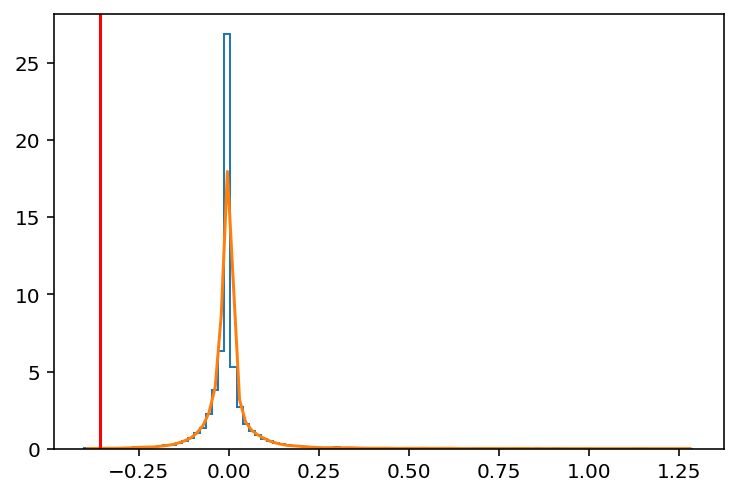

In [126]:
get_sep_th(terrain)

In [97]:
ths = 10**np.arange(-3,0,.25)

In [98]:
len(ths)

12

In [101]:
RegionSet = []
for th in ths:
    regions = Regions(terrain, min_gradient=th)
    regions.purge_lones(5)
    RegionSet += [regions]

deleted 227 rois
deleted 274 rois
deleted 304 rois
deleted 346 rois
deleted 415 rois
deleted 504 rois
deleted 599 rois
deleted 718 rois
deleted 788 rois
deleted 825 rois
deleted 843 rois
deleted 845 rois


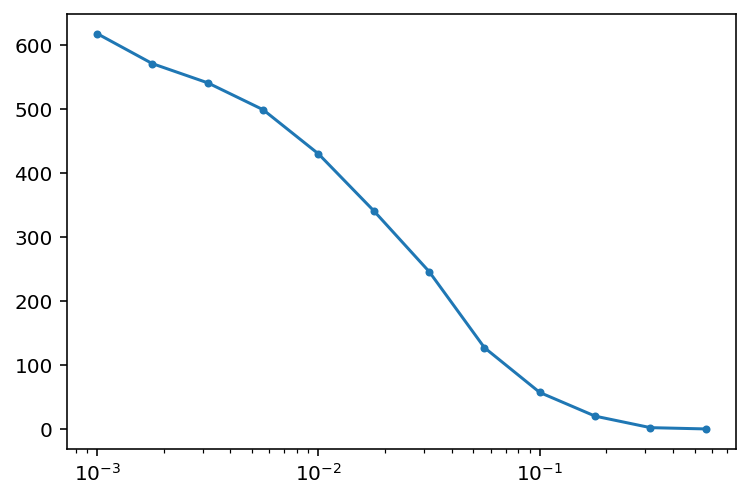

In [102]:
plt.plot(ths,[len(region.df) for region in RegionSet],".-")
plt.xscale("log")

In [122]:
m_resized = rebin(m_orig,10)

In [123]:
dm_resized = np.diff(m_resized,axis=0)

In [127]:
%%capture
images = OrderedDict([
    ("template", template),
    ("cc_res"  ,   m_resized.local_correlations(eight_neighbours=True,swap_dim=False)),
    ("std_res" ,   m_resized.std(axis=0)),
    ("mean_res",   m_resized.mean(axis=0)),
    ("cc_dres" ,  dm_resized.local_correlations(eight_neighbours=True,swap_dim=False)),
    ("std_dres",  dm_resized.std(axis=0)),
    ("mean_dres", dm_resized.mean(axis=0)),
])

<IPython.core.display.Javascript object>


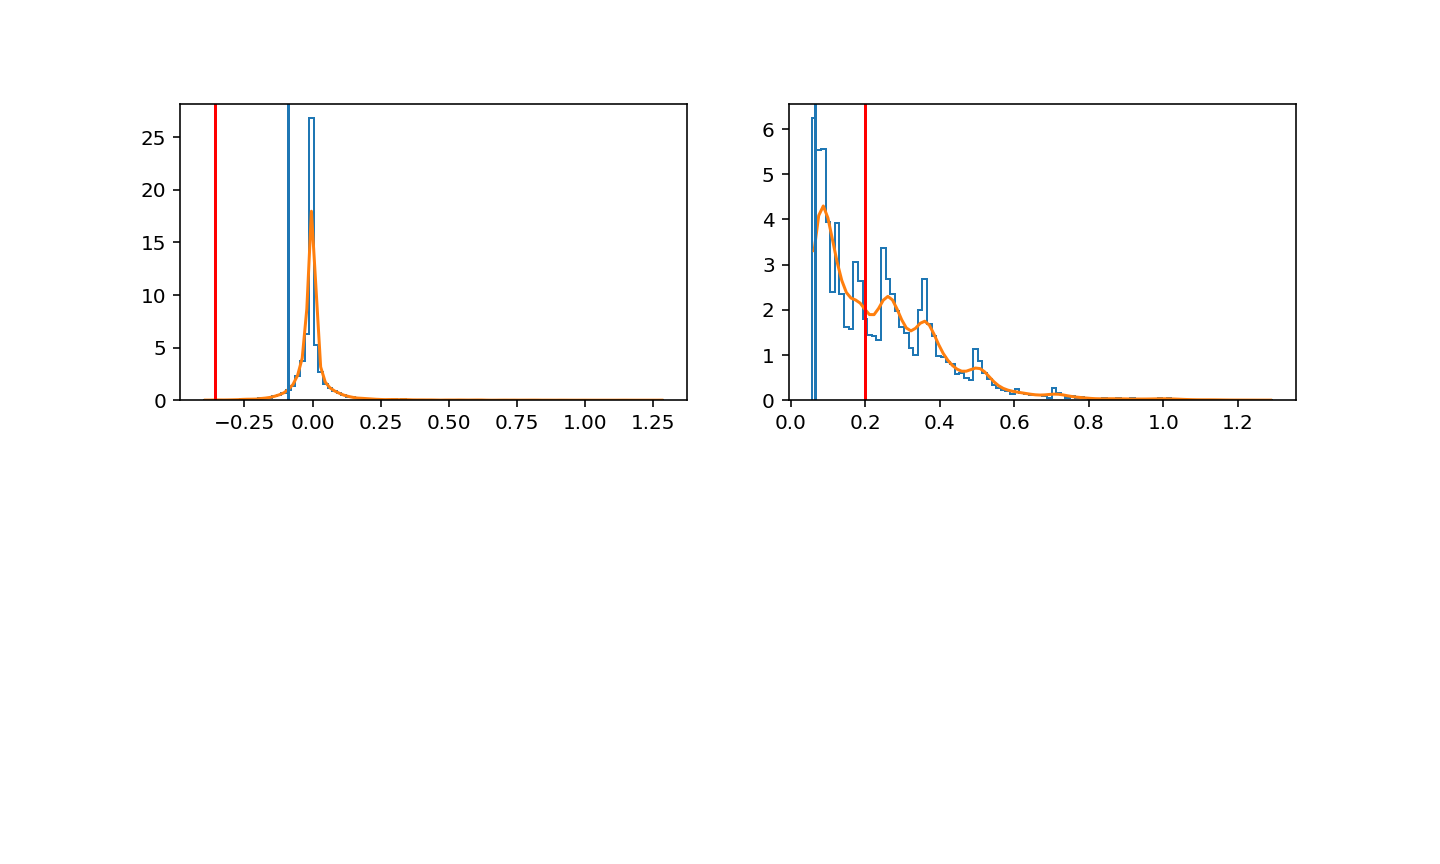

deleted 0 rois
deleted 16 rois


In [254]:
RegionSet = OrderedDict()
fig = plt.figure(figsize=(10,6))
for j,terrain in enumerate(["template",#"cc_res","cc_dres",
                            "std_dres"]):
    plt.subplot(2,2,j+1)
    x = images[terrain].astype('float')
    th = get_sep_th(x)
#     if np.mean(x<th)<.05 or np.mean(x<th)>.5:
    th = np.percentile(x.flatten(),5)
    regions = Regions(x.astype("float"),th=th)
    regions.purge_lones(5)
    RegionSet[terrain] = regions
    plt.axvline(th)

<IPython.core.display.Javascript object>


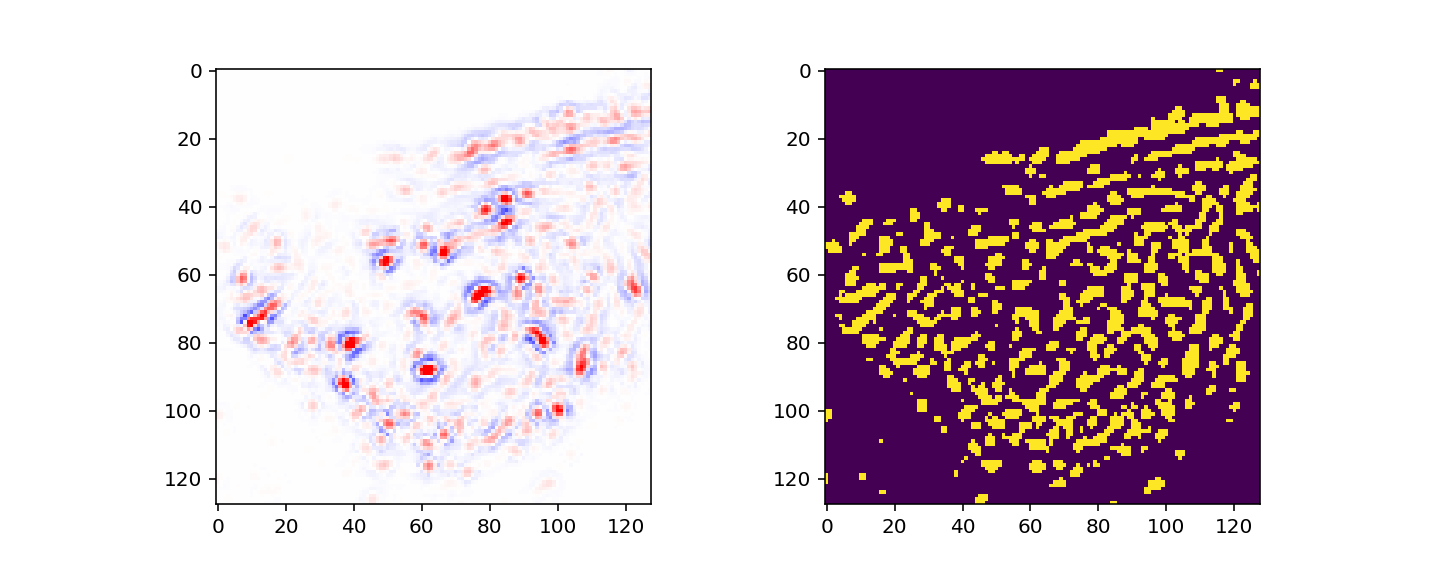

In [255]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
vmax = np.percentile(np.abs(template),99.7)
axs[0].imshow(template,vmin=-vmax,vmax=vmax,cmap="bwr")
axs[1].imshow(template>0.01)

In [260]:
regions = Regions(template,th = .0)

In [261]:
regions.purge_lones(5)

deleted 76 rois


In [262]:
RegionSet["template_th"] = regions

In [192]:
%matplotlib notebook

<IPython.core.display.Javascript object>


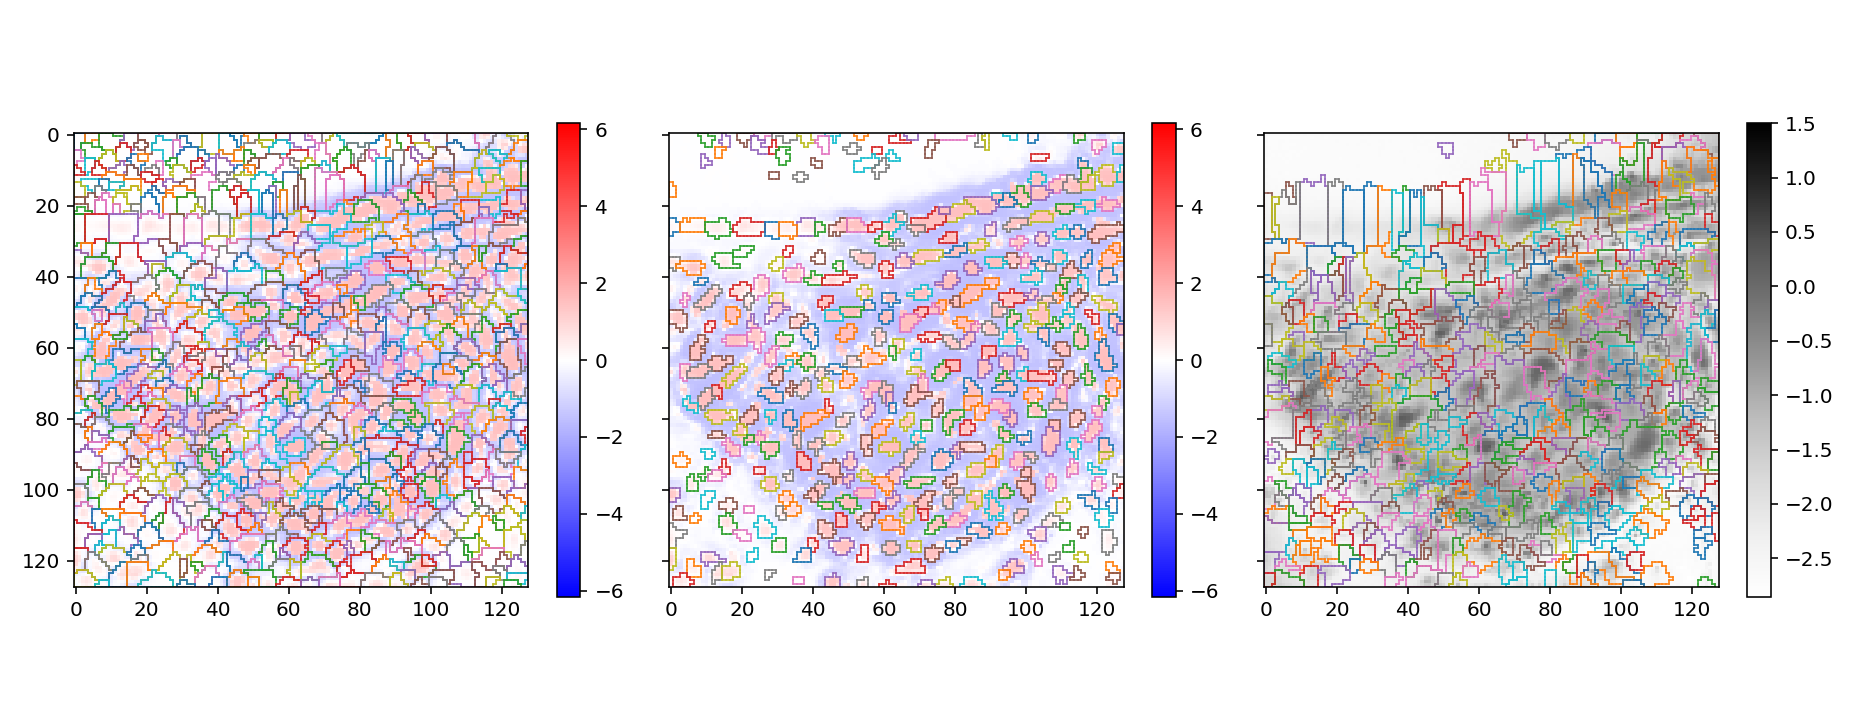

In [271]:
fig, axs = plt.subplots(1,3,figsize=(13,5), sharex=True, sharey=True)
for terrain,ax in zip(["template","template_th"], axs[:2]):
    regions = RegionSet[terrain]
    x = np.arctan(100*regions.image.astype(float))
    v = np.percentile(np.abs(x),99)*4
    im = ax.imshow(x,cmap="bwr", vmin=-v, vmax=v)
    plt.colorbar(im,ax=ax,shrink=.7)
    regions.plotEdges(ix = regions.df.query("size>5").index,separate=True,ax = ax, image=False,)

ax = axs[-1]
regions = RegionSet["std_dres"]
v = np.percentile(np.abs(x),99)*4
x = np.log(1e-3+regions.image.astype(float))
im = ax.imshow(x,cmap="Greys",vmax = 1.5)
plt.colorbar(im,ax=ax,shrink=.7)
regions.plotEdges(ix = regions.df.query("size>10").index,separate=True,ax = ax, image=False,)
fig.tight_layout()

<IPython.core.display.Javascript object>


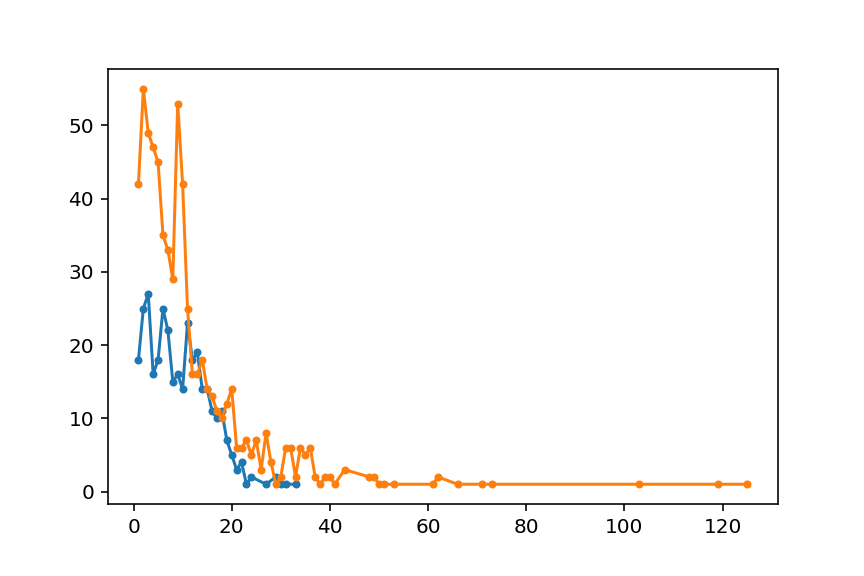

In [248]:
plt.figure()
for terrain in ["template","std_dres"]:
    cnt = Counter(RegionSet[terrain].df["size"])
    cnt = pd.Series(cnt)
    cnt = cnt.sort_index()
    plt.plot(cnt.index,cnt,".-")

In [272]:
regions = RegionSet["template_th"]

In [279]:
regions.calcTraces(m_orig)

(596, 331933)


In [280]:
# dt = .333
ironScale = 5.
wIron = int(ironScale*m_orig.fr)
if wIron%2==0:
    wIron += 1
print(wIron)
filterPars = (wIron,wIron,50.,2)

421


In [281]:
%%capture
lowPass(regions.df["trace"].iloc[0],*filterPars)

In [282]:
time.max()

3937.387

In [283]:
from general_functions import multi_map

In [284]:
C = regions.df

In [286]:
def iterf(x_):
    return lowPass(x_,*filterPars)

C["slower_%g"%ironScale] = multi_map(iterf,C["trace"].values,processes=15)
# C["slower_%g"%ironScale] = [iterf(tr) for tr in C.loc[:,"trace"]]

In [287]:
C["faster_%g"%ironScale] = [C.loc[i,"trace"] - C.loc[i,"slower_%g"%ironScale] for i in C.index]

In [288]:
mad2std = 1.4826

In [289]:
def iterf(x_):
    out = mad2std*percFilter(np.abs(x_),50.,5*wIron)
    out = runningAverage(out,5*wIron)
    return out

C["faster_%g_std"%ironScale] = multi_map(iterf,C["faster_%g"%ironScale].values,processes=15)

# Investigate results

In [590]:
# plotting definition
def plotInteresting(investigateIndex_, onlyImage=False):
    fig, axs = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
    for ax,im in zip(axs,["std_dres","template"]):
        showImage = images[im].astype("float")
        if im=="std_dres":
            ax.imshow(.01+showImage,cmap="Greys",norm=LogNorm(),vmax=showImage.max()*10)
        else:
            x = np.arctan(30*showImage)
            v = np.percentile(np.abs(x),99)*4
            im = ax.imshow(x,cmap="bwr", vmin=-v, vmax=v)
        regions.plotEdges(ix=investigateIndex_,separate=True,image=False, ax=ax)
        regions.plotPeaks(ix=investigateIndex_,image=False, ax=ax,labels=True)
    fig.show()
    
    if onlyImage: return None

    fig, axs = plt.subplots(2,1,figsize=(13,10), sharex=True)
    ia = 0
    n = 1
    ns = 2

    # inax = inset_axes(axs[0],
    #                     width="30%", # width = 30% of parent_bbox
    #                     height=1.2, # height : 1 inch
    #                     loc=2)
    # showImage = images["std_dres"].astype("float")
    # inax.imshow(.1+showImage,cmap="Greys",norm=LogNorm(),vmax=showImage.max()*10)
    # regions.plotEdges(ix=investigateIndex_,separate=True,ax=inax)
    t = rebin(time,n)
    for roi in investigateIndex_:
        x  = rebin(C.loc[roi,"trace"],n)
        xf = rebin(C.loc[roi,"faster_%g"%ironScale],n)
        xsd= rebin(C.loc[roi,"faster_%g_std"%ironScale],n)/n**.5
        xs = rebin(C.loc[roi,"slower_%g"%ironScale],n)
        eventFilter = posRender[np.where(C.index==roi)[0][0]]

        xsd= xsd/xf.std()
        xf = xf/xf.std()

        c  = "C%i"%(roi%10)
        axs[0].plot(t,x [::],c=c,lw=.4,alpha = .3)
        axs[0].plot(t,xs[::],c=c,lw=.7,alpha = 1)
        axs[0].plot(t[eventFilter],xs[eventFilter],".",c=c,ms=2,alpha = .2)
        yoffset = 13*ia
        axs[1].plot(t,xf[::]+yoffset,c=c,lw=.3)
        axs[1].plot(t,+ns*xsd[::]+yoffset,c=c,lw=.7)
        axs[1].plot(t,-ns*xsd[::]+yoffset,c=c,lw=.7)
        axs[1].axhline(yoffset,color=c,label=roi)
        axs[1].text(0,yoffset,str(roi)+" ",fontdict={"color":c},ha="right",va="center")
        axs[0].text(0,xs[0],str(roi)+" ",fontdict={"color":c},ha="right",va="center")
    # axs[1].legend(loc=(1.01,.01))
    # #     x,y = C.loc[roi,"peak"]#np.mean(C.loc[i,"pixels"],axis=0)
    # #     inax.plot(x,y,"o",mfc="none",ms=C.loc[i,"size"]**.5/2,c=c,mew=.3)
    #     bb = list(C.loc[roi,"boundary"])
    #     bb += [bb[0]]
    #     x,y = np.array(bb).T
    #     inax.plot(x,y,c=c,lw=.5)
        ia += 1
    # yl = axs[0].get_ylim()[1]
    # axs[0].set_ylim(None,yl*1.2)

    # plt.xticks([])
    # plt.yticks([])
    fig.tight_layout()
    fig.show()

In [428]:
sum([np.isnan(x).sum() for x in  C["faster_%g_std"%ironScale]])

0

In [448]:
nZerosStd = np.array([(x==0).sum() for x in  C["faster_%g_std"%ironScale]])

<IPython.core.display.Javascript object>


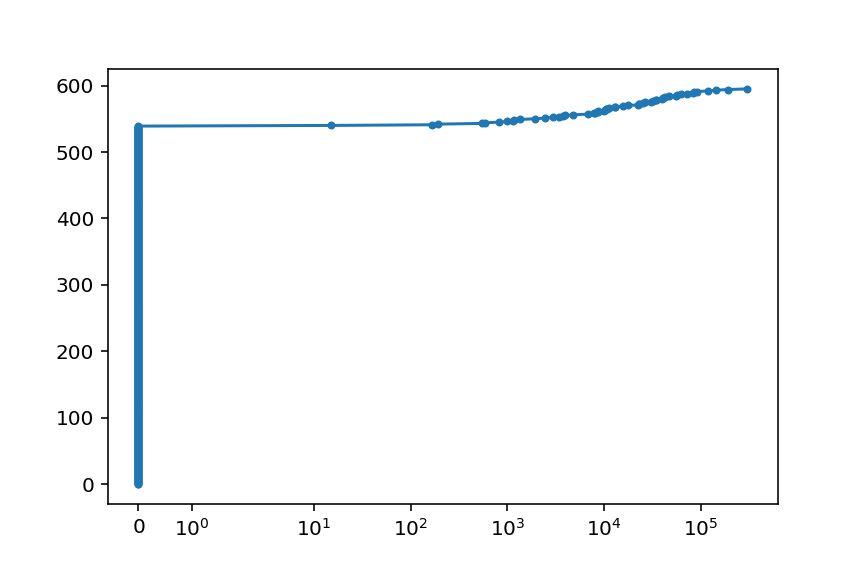

In [450]:
plt.figure()
plt.plot(sorted(nZerosStd),np.arange(len(C)),".-")
plt.xscale("symlog")

In [453]:
toDrop = C.index[nZerosStd>100]

In [455]:
C.drop(index=toDrop,inplace=True)

In [550]:
try:
    toDrop = C.query("negZmean<1e-5").index
    C.drop(index=toDrop,inplace=True)
    print ("dropped %i rois"%len(toDrop))
except:
    pass

dropped 220 rois


In [551]:
zscore = np.vstack(C["faster_%g"%ironScale])/(1e-3+np.vstack(C["faster_%g_std"%ironScale]))
# print ((~np.isfinite(zscore)).sum())
# print (np.nanmin(zscore), np.nanmax(zscore))

In [552]:
zth = 3
negRender = zscore<-zth
posRender = zscore>+zth

In [553]:
# offset = posRender.mean(axis=1).min()/2
offset = negRender.mean(axis=1)
offset = offset[offset>0].min()
C["negZmean"] = offset+negRender.mean(axis=1)
C["posZmean"] = offset+posRender.mean(axis=1)

In [554]:
C["lognegZmean"] = np.log10(C["negZmean"])
C["logposZmean"] = np.log10(C["posZmean"])

In [572]:
C["slowMean"] = np.log10(C["slower_%g"%ironScale].apply(np.mean))

In [528]:
import plotly_express as px

In [585]:
# investigateIndex = np.random.choice(C.query("size>=10").index,20)
investigateIndex = np.random.choice(C.query("size>1 and posZmean>0.01").index,10)
investigateIndex = np.unique(investigateIndex)
# investigateIndex = np.concatenate([[272,649,599,580], investigateIndex])
print (len(investigateIndex))
C['invest'] = [1 if i in investigateIndex else 0 for i in C.index]

4


In [586]:
# px.scatter_3d(C,"lognegZmean","slowMean","logposZmean",size="size",size_max=40,
#            hover_name=C.index,)

In [587]:
px.scatter(C,"lognegZmean","logposZmean",size="size",
#            log_x=True,log_y=True,
           hover_name=C.index,
#            color=None if "invest" not in C else C["invest"],
           color=C["slowMean"],
#            facet_col="invest",
           height=600,width=700,
           marginal_x="histogram",
           marginal_y="histogram",
          )

<IPython.core.display.Javascript object>


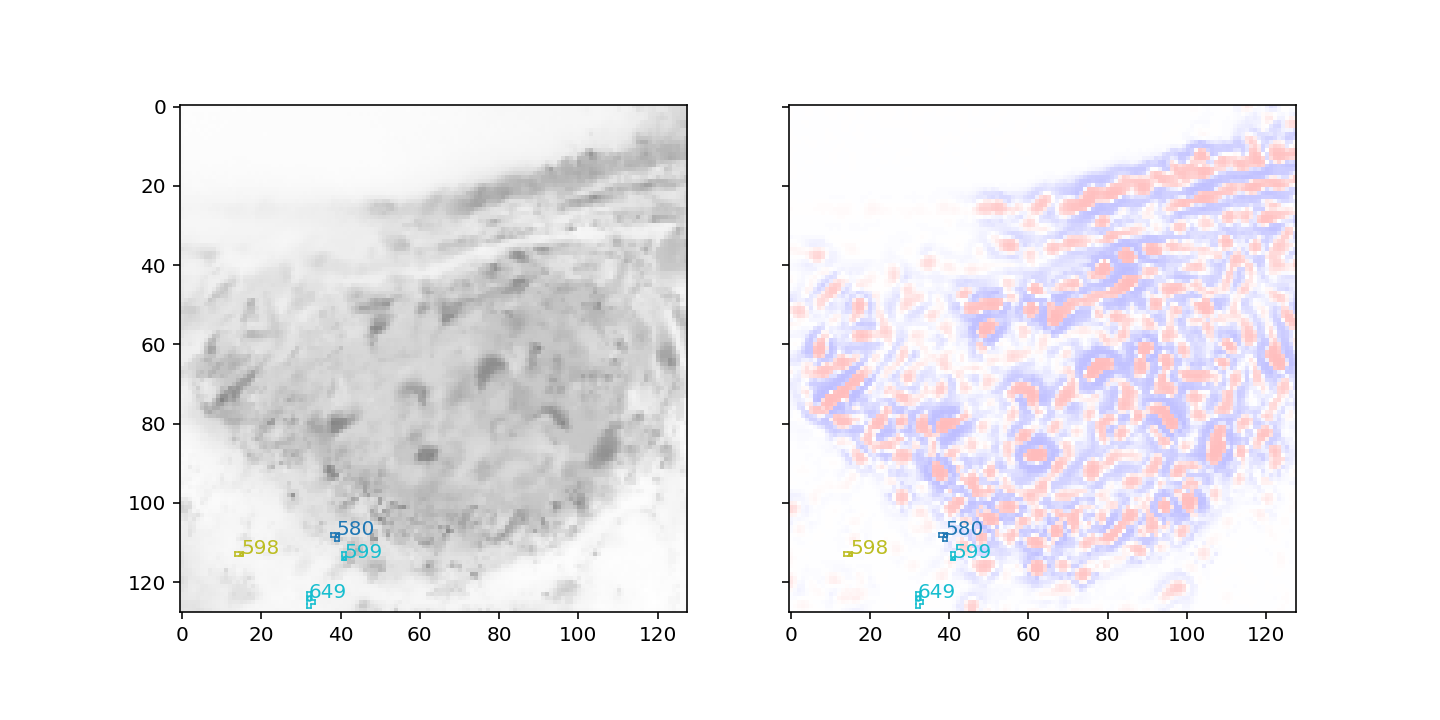

<IPython.core.display.Javascript object>


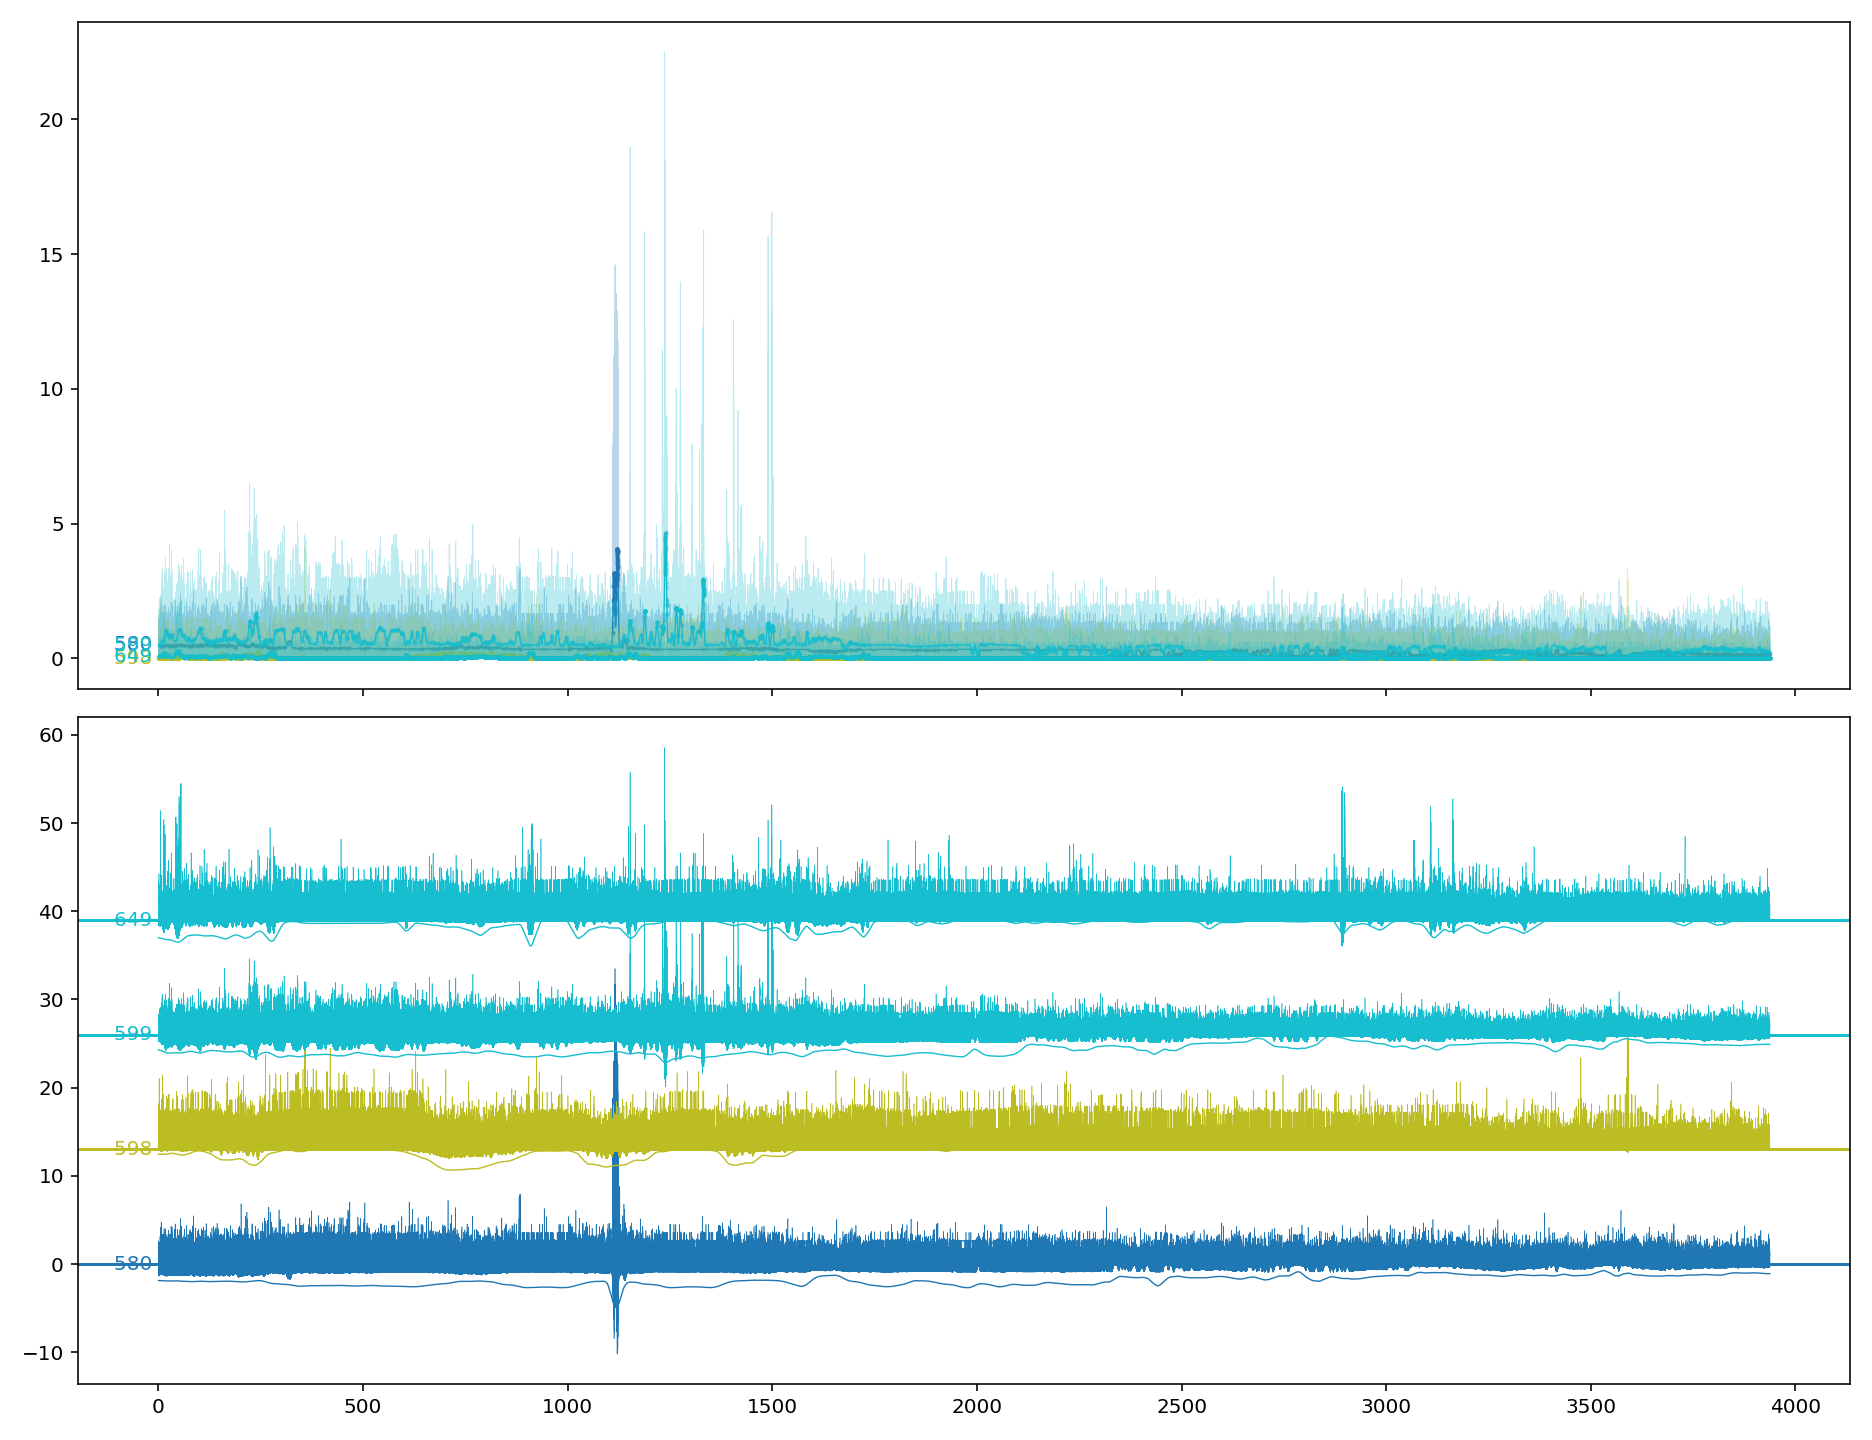

In [591]:
plotInteresting(investigateIndex[:],
#                 onlyImage=True
               )

In [592]:
# plt.figure()
# plt.hist(np.diff(np.where(eventFilter)[0]))

In [594]:
regionSaveName = baseName+"_regions.pkl"

In [595]:
import pickle

In [597]:
regions.std_dres_image = images["std_dres"].astype(float)

In [601]:
if os.path.isfile(regionSaveName):
    print (regionSaveName, "exists. Please choose a different name.")
else:
    with open(regionSaveName,"wb") as f:
        pickle.dump(regions,f)

In [602]:
regionSaveName

'local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_1_Series006-008_regions.pkl'

# Show Movie

In [297]:
timeSlice = slice(int(len(m_orig)*.0),int(len(m_orig)*1))

nTimeFrames = 200
nRebinShow = len(m_orig[timeSlice])//nTimeFrames
border = np.ones((nTimeFrames,1,m_orig.shape[-1]))*m_orig.max()
m2show = rebin(m_orig[timeSlice].astype(np.float32), nRebinShow)
# m2show = concatenate([
#     rebin(m_orig[timeSlice], nRebinShow),
#     border,
#     rebin(m_corr[timeSlice], nRebinShow),
# ],axis=1)

# showMovie(np.log(1+m2show),figsize=(13,6))

In [298]:
m2show.min(), m2show.max(), np.percentile(m2show,99.5)

(movie(0., dtype=float32), movie(64.4489, dtype=float32), 13.669666371345517)

In [301]:
# showMovie(np.log(.1+m2show),figsize=(7,6))

In [302]:
from sys import getsizeof